Other example of Jupyter notebook using GRASS GIS can be found [HERE](https://grasswiki.osgeo.org/wiki/GRASS_GIS_Jupyter_notebooks)

# Configuration of the working environment

## Import libraries and define GRASS python path

**Importing Python libraries and modules**

In [1]:
# Import base Python libraries 
import os
import sys
import subprocess
# Import Pandas library
import pandas as pd
# Import Numpy library
import numpy as np
# Import SciPy library
import scipy as scipy
# Import IPython packages for display in the notebook
from IPython.display import Image

**Add folder with SCR provided belong to this notebook**

In [2]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

**Setup environment variables**

Please edit the file in `../SRC/config.py`, containing the configuration parameters, according to your own computer setup. The following cell is used to run this file.



In [3]:
run ../SRC/config_linux.py

In [4]:
# Import functions that setup the environmental variables
import environ_variables_linux as envi

In [5]:
# Set environmental variables
envi.setup_environmental_variables() 
# Display current environment variables of your computer
envi.print_environmental_variables()

PATH	= /.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/grass78/bin:/usr/lib/grass78/script:/usr/lib/grass78/lib 	
HOSTNAME	= 24a67b9a0970 	
DISPLAY	= unix:1 	
LANG	= C.UTF-8 	
LC_ALL	= C.UTF-8 	
JUPYTER_ENABLE_LAB	= yes 	
TINI_VERSION	= v0.6.0 	
HOME	= /home/demo_user 	
JPY_PARENT_PID	= 7 	
TERM	= xterm-color 	
CLICOLOR	= 1 	
PAGER	= cat 	
GIT_PAGER	= cat 	
MPLBACKEND	= module://ipykernel.pylab.backend_inline 	
PYTHONPATH	= :/usr/lib/grass78/etc/python:/usr/lib/grass78/etc/python/grass:/usr/lib/grass78/etc/python/grass/script 	
LD_LIBRARY_PATH	= :/usr/lib/grass78/lib 	
GISBASE	= /usr/lib/grass78 	
PYTHONLIB	= /usr/bin/python3 	
GIS_LOCK	= $$ 	
GISRC	= /home/demo_user/.grass7/rc 	


**Importing GRASS GIS libraries and modules**

In [6]:
#Import libraries needed to launch GRASS GIS in the Jupyter Notebook
import grass.script.setup as gsetup
#Import libraries needed to call GRASS using Python
import grass.script as gscript

**Importing other functions**

In [7]:
# Import function that checks existence of GRASS GIS database folder and creates it if needed
from grass_database import check_gisdb, check_location, check_mapset, working_mapset, launch_mapset
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import function that checks if GRASS GIS add-on is installed and install it if needed
from gextension import check_install_addon

**Create output directory if not exists**

In [8]:
#Check and create output data directory if needed
outputdir = '/home/demo_user/output_container/OBIA'
check_create_dir(outputdir)

The folder '/home/demo_user/output_container/OBIA' has been created


**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

## Setup GRASS GIS session and specific environment variables

In [9]:
# Create a GRASS GIS session.
rcfile = gsetup.init(config_parameters['GISBASE'], "../../GRASSDATA", "nc_spm_08_grass7", "user1")

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gscript.set_raise_on_error(True)
gscript.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Install required GRASS addons

In [10]:
# Create mapset 
launch_mapset("PERMANENT")

["Location 'nc_spm_08_grass7' already exist",
 "'PERMANENT' mapset already exists in location 'nc_spm_08_grass7'",
 "You are now working in mapset 'nc_spm_08_grass7/PERMANENT'"]

In [11]:
# Check if add-on is already installed in the computer and install it not yet installed
check_install_addon("r.object.geometry")
check_install_addon("i.segment.stats")
check_install_addon("v.class.mlR")

r.object.geometry have been installed on your computer
i.segment.stats have been installed on your computer
v.class.mlR have been installed on your computer


# Example of OBIA processing

## List raster layers, display RGB composition

We list the raster maps in the current mapset using [list_string](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.list_strings), using regular expression. Other methods exists such as [list_pairs](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.list_pairs) or [list_grouped](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.list_grouped).

These are Landsat 7 bands. For more information on the spectral range of each bands, please refer to the USGS documentation [HERE](https://www.usgs.gov/media/images/landsat-4-5-tm-and-landsat-7-etm-bands-and-their-uses). 

In [12]:
# Print list of landsat bands
landsat_bands = gscript.list_strings("rast", pattern="lsat7", mapset="PERMANENT", flag='r')
for rast in landsat_bands:
    print(rast)

lsat7_2002_10@PERMANENT
lsat7_2002_20@PERMANENT
lsat7_2002_30@PERMANENT
lsat7_2002_40@PERMANENT
lsat7_2002_50@PERMANENT
lsat7_2002_61@PERMANENT
lsat7_2002_62@PERMANENT
lsat7_2002_70@PERMANENT
lsat7_2002_80@PERMANENT


In [13]:
# Define the default computational region
gscript.run_command('g.region', flags='s', raster='lsat7_2002_20@PERMANENT')

0

Then, we display a RGB true-color composite

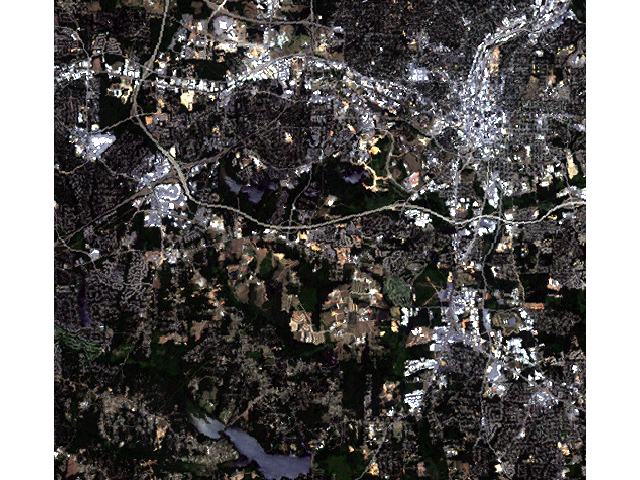

In [14]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Apply histogram equalisation
gscript.run_command('i.colors.enhance', blue='lsat7_2002_10', green='lsat7_2002_20', red='lsat7_2002_30')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rgb', blue='lsat7_2002_10', green='lsat7_2002_20', red='lsat7_2002_30')
# Display
Image(filename="map.png")

Alternatively, we can display a RGB false-color near-infrared composite

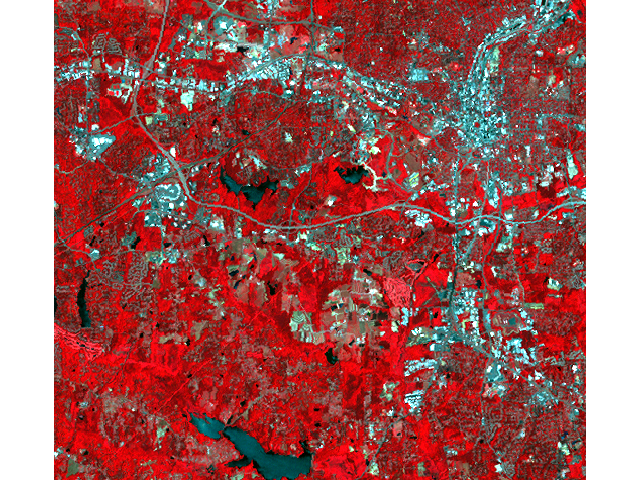

In [15]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Apply histogram equalisation
gscript.run_command('i.colors.enhance', blue='lsat7_2002_20', green='lsat7_2002_30', red='lsat7_2002_40')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rgb', blue='lsat7_2002_20', green='lsat7_2002_30', red='lsat7_2002_40')
# Display
Image(filename="map.png")

## Compute NDVI

In [16]:
# Create mapset 
launch_mapset("user1")

["Location 'nc_spm_08_grass7' already exist",
 "'user1' mapset already exists in location 'nc_spm_08_grass7'",
 "You are now working in mapset 'nc_spm_08_grass7/user1'"]

Now, we will compute [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using [r.mapcal](https://grass.osgeo.org/grass76/manuals/r.mapcalc.html) in its [Python scripting package version](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.raster.mapcalc).

In [17]:
# Define computational region
gscript.run_command('g.region', flags='d')
# The raster formula to be used
formula = "ndvi=float(lsat7_2002_40-lsat7_2002_30)/float(lsat7_2002_40+lsat7_2002_30)"
# Compute NDVI using
gscript.mapcalc(formula)

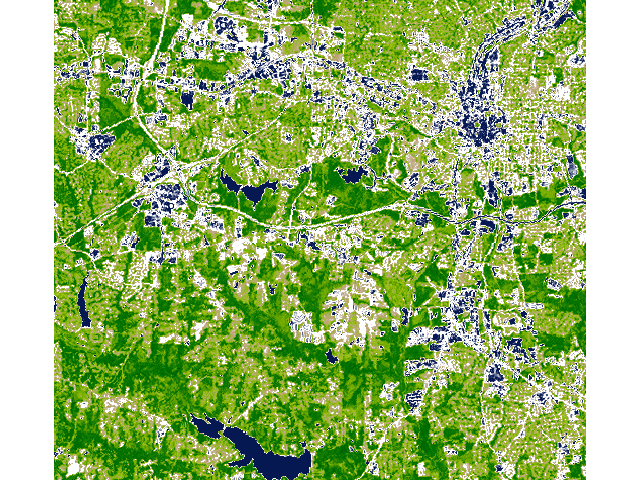

In [18]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Apply colors for NDVI
gscript.run_command('r.colors', map='ndvi', color='ndvi')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rast', map='ndvi')
# Display
Image(filename="map.png")

## Create imagery group

First, we will create a group of imagery for the segmentation. Two options are demonstrated. 

**OPTION A: write the name of the raster layers in string**

In [19]:
# Create imagery group - Option A
gscript.run_command('i.group', 
                    group='vnir', 
                    input="lsat7_2002_10@PERMANENT,lsat7_2002_20@PERMANENT,lsat7_2002_30@PERMANENT,lsat7_2002_40@PERMANENT"
                   )

0

To print the list of band in the group, we can use the fonction [read_command](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.read_command) inside the Python print().

In [20]:
# List raster in group
print(gscript.read_command('i.group', group='vnir', flags='l'))

group <vnir> references the following raster maps
-------------
<lsat7_2002_10@PERMANENT>    <lsat7_2002_20@PERMANENT>    
<lsat7_2002_30@PERMANENT>    <lsat7_2002_40@PERMANENT>    
-------------



We will remove the imagery group to demonstrate the option B

In [21]:
gscript.run_command('g.remove', flags='f', type='group', name='vnir')

0

**OPTION B: use the join() fonction of python list to create the content of the input parameter of i.group**

In [22]:
# Create imagery group - Option B
gscript.run_command('i.group', group='vnir', input=','.join(landsat_bands[:4])) # Here, only the landsat bands are added to the group

0

Instead of using read_command, we can use [parse_command](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.parse_command) which return a dictionnary with the output of the Grass command (notice we are using -g flag to force to ouput in shell script style). The dictionnary is transformed into a list with the list() fonction of Python.

In [23]:
# List raster in group
group_list = list(gscript.parse_command('i.group', group='vnir', flags='gl'))
group_list

['lsat7_2002_10@PERMANENT',
 'lsat7_2002_20@PERMANENT',
 'lsat7_2002_30@PERMANENT',
 'lsat7_2002_40@PERMANENT']

## Segmentation

Now, we perform segmentation using [i.segment](https://grass.osgeo.org/grass78/manuals/i.segment.html). Then, we compute segment statistics (shape and raster-based statistics) with [i.segment.stats](https://grass.osgeo.org/grass78/manuals/addons/i.segment.stats.html). 

The segmentation parameter have been identified manually with some trial-and-error attempts. More advanced approaches exists, such as using [i.segment.uspo](https://grass.osgeo.org/grass78/manuals/addons/i.segment.uspo.html) or even [SPUSPO](https://www.mdpi.com/2072-4292/10/9/1440).

In [24]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Perform segmentation
gscript.run_command('i.segment', group='vnir', output='segment', threshold='0.05', minsize='10')

0

By reading the raster informations, we knwo how many segment we produced. The number of segment produced correspond to the 'max' value.

In [25]:
segment_info = gscript.raster_info('segment')
print("Our segmentation raster contains %i segments" %segment_info['max'])
segment_info

Our segmentation raster contains 3602 segments


{'north': 228513.0,
 'south': 214975.5,
 'east': 645012.0,
 'west': 629992.5,
 'nsres': 28.5,
 'ewres': 28.5,
 'rows': '475',
 'cols': '527',
 'cells': '250325',
 'datatype': 'CELL',
 'ncats': '0',
 'min': 1.0,
 'max': 3602.0,
 'map': 'segment',
 'maptype': 'raster',
 'mapset': 'user1',
 'location': 'nc_spm_08_grass7',
 'database': '/home/demo_user/GRASSDATA',
 'date': '"Fri Feb 18 14:25:09 2022"',
 'creator': '"demo_user"',
 'title': '""',
 'timestamp': '"none"',
 'units': '"none"',
 'vdatum': '"none"',
 'source1': '""',
 'source2': '""',
 'description': '"generated by i.segment"',
 'comments': '"i.segment group="vnir" output="segment" threshold=0.05 radius=1.5 me\\thod="region_growing" similarity="euclidean" minsize=10 memory=300"'}

Now, we will display our segmentation raster

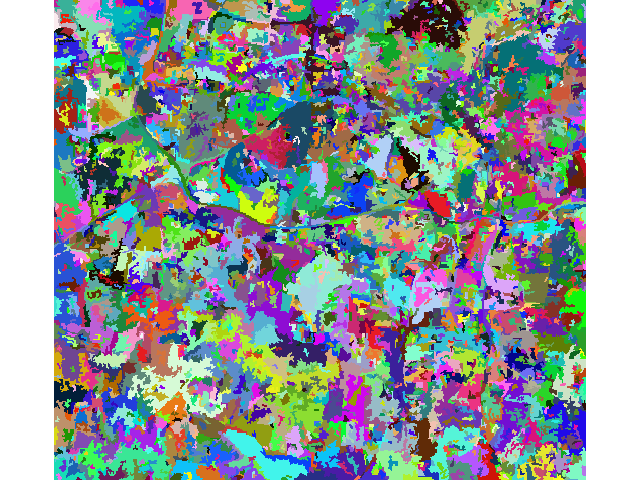

In [26]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rast', map='segment')
# Display
Image(filename="map.png")

For more convenience, we will vectorize the segmentation and display it as overlay of the false-color composite

In [27]:
# Convert raster into vector
gscript.run_command('r.to.vect', input='segment', output='segment_vect', type='area')

0

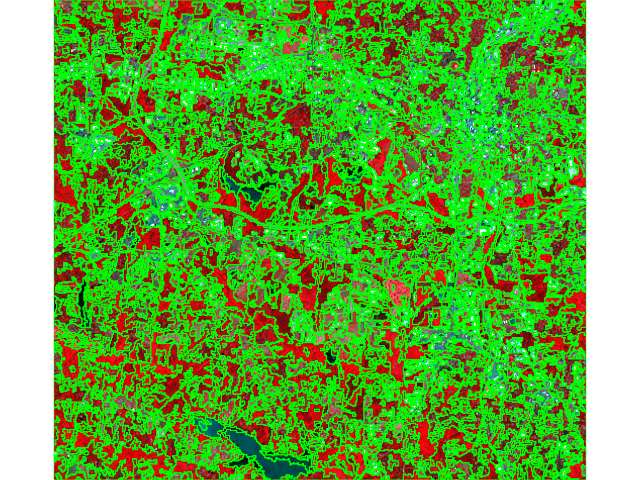

In [28]:
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rgb', blue='lsat7_2002_20', green='lsat7_2002_30', red='lsat7_2002_40')
gscript.run_command('d.vect', map='segment_vect', color='0:255:0:255', fill_color='none', width='-1')
Image(filename="map.png")

## Compute segment stats

In [29]:
# Compute segment statistics
raster_list = list(landsat_bands) #list() is needed to make hard copy
raster_list.append('ndvi')
stat_csv = os.path.join(outputdir,'stats.csv')
gscript.run_command('i.segment.stats', map='segment', rasters=','.join(raster_list), csvfile=stat_csv, vectormap='segment_stats', processes='3')

0

We will display the head of the csv file with Pandas

In [30]:
df_stats = pd.read_csv(stat_csv,sep='|')
df_stats.head(6)

,cat,area,perimeter,compact_circle,fd,lsat7_2002_10_mean,lsat7_2002_10_stddev,lsat7_2002_10_sum,lsat7_2002_20_mean,lsat7_2002_20_stddev,...,lsat7_2002_40_sum,lsat7_2002_50_mean,lsat7_2002_50_stddev,lsat7_2002_50_sum,lsat7_2002_70_mean,lsat7_2002_70_stddev,lsat7_2002_70_sum,ndvi_mean,ndvi_stddev,ndvi_sum
0,1,25.0,32.0,1.805407,2.153356,71.480000,2.594147,1787,54.800000,3.298485,...,2921,81.360000,12.964197,2034,37.280000,10.351889,932,0.471646,0.107889,11.791138
1,2,16.0,22.0,1.551521,2.229666,77.312500,8.144927,1237,61.312500,9.680643,...,1690,97.750000,29.479866,1564,52.562500,23.229746,841,0.336115,0.166879,5.377841
2,3,11.0,16.0,1.360876,2.312431,68.545455,1.304791,754,52.000000,1.279204,...,1366,71.545455,7.426778,787,29.727273,3.933329,327,0.557785,0.021714,6.135634
3,4,34.0,38.0,1.838397,2.063065,68.147059,1.629369,2317,53.794118,1.676471,...,4282,75.470588,4.791139,2566,31.352941,1.892436,1066,0.554995,0.025234,18.869832
4,5,49.0,52.0,2.095561,2.030527,73.224490,3.085617,3588,60.489796,4.300557,...,6143,105.081633,17.823210,5149,49.469388,10.832871,2424,0.456405,0.075030,22.363837
5,6,307.0,156.0,2.511600,1.763572,86.351792,5.274240,26510,76.159609,6.837618,...,31101,145.504886,20.351211,44670,86.146580,15.257871,26447,0.115064,0.094792,35.324582


## Import training labels and link them with segment stats

In [32]:
# Import vector layer with training points
gscript.run_command('v.import', input='/home/demo_user/Workshop/Qgis_training_sample/Training_NC.gpkg', layer='Training_NC', output='Training_NC')
# Save the segment ID corresponding to each training point 
gscript.run_command('v.what.rast', map='Training_NC', raster='segment', column='segment_id')
# Export the attribute table to a csv file and display it
label_csv = os.path.join(outputdir,'training_labels.csv')
gscript.run_command('db.out.ogr', input='Training_NC', output=label_csv, format='CSV')
df_labels = pd.read_csv(label_csv)
df_labels.head(3)

,cat,label,segment_id
0,1,22,481
1,2,22,6
2,3,22,1231


In [33]:
# Join the training and the labels
df_training = pd.merge(df_stats, df_labels, how="inner",left_on='cat',right_on='segment_id')
df_training.drop(columns=['cat_x','cat_y','segment_id'], inplace=True)
df_training.head(4)

,area,perimeter,compact_circle,fd,lsat7_2002_10_mean,lsat7_2002_10_stddev,lsat7_2002_10_sum,lsat7_2002_20_mean,lsat7_2002_20_stddev,lsat7_2002_20_sum,...,lsat7_2002_50_mean,lsat7_2002_50_stddev,lsat7_2002_50_sum,lsat7_2002_70_mean,lsat7_2002_70_stddev,lsat7_2002_70_sum,ndvi_mean,ndvi_stddev,ndvi_sum,label
0,307.0,156.0,2.511600,1.763572,86.351792,5.274240,26510,76.159609,6.837618,23381,...,145.504886,20.351211,44670,86.146580,15.257871,26447,0.115064,0.094792,35.324582,22
1,38.0,40.0,1.830473,2.028187,152.342105,28.366285,5789,144.736842,30.463683,5500,...,185.315789,52.637842,7042,171.684211,56.603006,6524,-0.264532,0.056498,-10.052217,1
2,61.0,38.0,1.372504,1.769732,69.229508,2.478719,4223,53.606557,2.090405,3270,...,75.672131,4.321966,4616,31.409836,2.335591,1916,0.568550,0.034907,34.681527,21
3,503.0,314.0,3.949487,1.848503,88.147117,6.130638,44338,77.560636,7.225961,39013,...,144.652087,22.762850,72760,84.771372,16.479200,42640,0.137811,0.103673,69.318861,22


In [34]:
# Export csv with trainint stats
training_csv = os.path.join(outputdir,'training.csv')
df_training.to_csv(label_csv)

## Classification

Now, we will perform the classification using [v.class.mlR](https://grass.osgeo.org/grass78/manuals/addons/v.class.mlR.html). 
This add-on will launch a R script in the background. The first time you run it, it needs to install several R packages, so it can take a while (about X minutes).

In [ ]:
# Classification using v.class.mlR
gscript.run_command('v.class.mlR',
                    segments_file=stat_csv,
                    training_file=training_csv,
                    raster_segments_map='segment',
                    classified_map='classif',
                    train_class_column='label',
                    output_class_column='vote',
                    output_prob_column='prob',
                    folds='5', partitions='10', tunelength='10',
                    weighting_modes='smv,swv',
                    weighting_metric='accuracy',
                    r_script_file=os.path.join(outputdir,'vclassmlr.R'),
                    processes='7')

In [ ]:
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', image='lsat7_2002_20')
Image(filename="map.png")

More advance classification procedure with R can be perform with %%R magic cells. For an example check [HERE](https://github.com/tgrippa/Semi_automated_OBIA_processing_with_local_USPO/blob/f6b04492e443fcf02a3a071ad563110a740ad0da/Classification/Classification.ipynb).